In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [2]:
rules = pd.read_csv("test-recommend-output-wocDepSeq3-all.csv")
#to_lib2max_freq = {to_lib: max(row["ruleFreqSameCommit"]) for to_lib, row in rules.groupby(by="toLib")}
#rules["ruleFreqToLibSameCommit"] = rules["ruleFreqSameCommit"] / rules["toLib"].apply(lambda x: to_lib2max_freq[x])
#rules.insert(4, "confTeyton", np.minimum(rules["ruleFreqSameCommit"], rules["ruleFreqToLibSameCommit"]).fillna(0))
to_lib2cnt = {to_lib: len(rows) for to_lib, rows in rules.groupby(by="toLib")}
from_lib2cnt = {from_lib: len(rows) for from_lib, rows in rules.groupby(by="fromLib")}
rules["confTeyton"] = (rules["ruleCountSameCommit"] / np.maximum(
    rules["toLib"].apply(lambda x: to_lib2cnt[x]),
    rules["fromLib"].apply(lambda x: from_lib2cnt[x])
)).fillna(0)
# to_lib2max_freq = {to_lib: max(row["ruleFreq"]) for to_lib, row in rules.groupby(by="toLib")}
# rules["ruleFreqToLib"] = rules["ruleFreq"] / rules["toLib"].apply(lambda x: to_lib2max_freq[x])
# rules["popularityRegularization"] = rules["ruleFreq"] * rules["concurrenceAdjustment"]
# from_lib2max_count = {from_lib: max(row["possibleCommitCount"]) for from_lib, row in rules.groupby(by="fromLib")}
# rules["commitMessageSupport"] = [x / (from_lib2max_count[from_lib] + 1) for from_lib, x in zip(rules["fromLib"], rules["possibleCommitCount"])]

In [3]:
from_libs = set()
with open("from-lib-confirmed.txt", "r") as f:
    from_libs = set(x.strip() for x in f)
len(from_libs), len(from_libs - set(rules["fromLib"]))

(195, 1)

In [4]:
import2vecs = dict()
with open("../embedding/java_w2v_dim100.txt", "r") as f:
    num_lib, num_dim = tuple(f.readline().split(" "))
    num_lib, num_dim = int(num_lib), int(num_dim)
    for line in f:
        vals = line.split(" ")
        import2vecs[vals[0]] = [float(x) for x in vals[1:]]
similarities = []
for f, t in zip(rules["fromLib"], rules["toLib"]):
    if f in import2vecs and t in import2vecs:
        similarities.append(
            np.dot(import2vecs[f], import2vecs[t]) 
            / (np.linalg.norm(import2vecs[f]) * np.linalg.norm(import2vecs[t])))
    else:
        similarities.append(0)
rules["similarity"] = similarities
print(len(rules[rules["similarity"] != 0]))

115026


In [5]:
ground_truth = pd.read_excel("manual/ground-truth.xlsx")
rules_existed = set(zip(rules["fromLib"], rules["toLib"]))
confirmed_rule_set = set(zip(
    ground_truth[ground_truth["isConfirmed"]]["fromLib"], 
    ground_truth[ground_truth["isConfirmed"]]["toLib"]
)) & rules_existed
possible_rule_set = (set(zip(
    ground_truth[ground_truth["ruleCount"] > 0]["fromLib"], 
    ground_truth[ground_truth["ruleCount"] > 0]["toLib"]
)) | confirmed_rule_set) & rules_existed

rules["isPossible"] = [x in possible_rule_set for x in zip(rules["fromLib"], rules["toLib"])]
rules.insert(2, "isConfirmed", [x in confirmed_rule_set for x in zip(rules["fromLib"], rules["toLib"])])
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
print("# rules = {}, # confirmed = {}, # possible = {}, # confirmed from libs = {}".format(
    len(rules), len(confirmed_rule_set), len(possible_rule_set), 
    len(set(x[0] for x in confirmed_rule_set))
))

# rules = 243152, # confirmed = 773, # possible = 1446, # confirmed from libs = 190


In [6]:
def evaluate(method, rules, possible_rules, confirmed_rules):
    top_k = 100
    top_rules = [list() for x in range(0, top_k)]
    ndcg_possible_at_k = [list() for x in range(0, top_k)]
    ndcg_confirmed_at_k = [list() for x in range(0, top_k)]
    from_lib_set = set(x for x, y in confirmed_rules)
    reciprocal_ranks_confirmed = {}
    reciprocal_ranks_possible = {}
    for from_lib, candidates in rules.groupby(by="fromLib"):
        if from_lib not in from_lib_set:
            continue
        this_rules = [(from_lib, to_lib) for to_lib in candidates["toLib"]]
        this_possible_rules = [(from_lib, to_lib) for from_lib, to_lib in this_rules if (from_lib, to_lib) in possible_rules]
        this_confirmed_rules = [(from_lib, to_lib) for from_lib, to_lib in this_rules if (from_lib, to_lib) in confirmed_rules]
        for k, (from_lib, to_lib) in enumerate(this_rules):
            if k >= top_k:
                continue
            top_rules[k].append((from_lib, to_lib))
            if (from_lib, to_lib) in possible_rules and from_lib not in reciprocal_ranks_possible:
                reciprocal_ranks_possible[from_lib] = 1 / (k + 1)
            if (from_lib, to_lib) in confirmed_rules and from_lib not in reciprocal_ranks_confirmed:
                reciprocal_ranks_confirmed[from_lib] = 1 / (k + 1)
            dcg_p = sum(int((from_lib, to_lib) in possible_rules) / np.log2(i+2) for i, (from_lib, to_lib) in enumerate(this_rules[0:k+1]))
            idcg_p = sum(1 / np.log2(i+2) for i in range(0, min(k + 1, len(this_possible_rules))))
            if idcg_p == 0:
                ndcg_possible_at_k[k].append(0)
            else:
                ndcg_possible_at_k[k].append(dcg_p / idcg_p)
            dcg_c = sum(int((from_lib, to_lib) in confirmed_rules) / np.log2(i+2) for i, (from_lib, to_lib) in enumerate(this_rules[0:k+1]))
            idcg_c = sum(1 / np.log2(i+2) for i in range(0, min(k + 1, len(this_confirmed_rules))))
            if idcg_c == 0:
                ndcg_confirmed_at_k[k].append(0)
            else:
                ndcg_confirmed_at_k[k].append(dcg_c / idcg_c)
        if from_lib not in reciprocal_ranks_possible:
            reciprocal_ranks_possible[from_lib] = 0
        if from_lib not in reciprocal_ranks_confirmed:
            reciprocal_ranks_confirmed[from_lib] = 0
    for k in range(1, top_k):
        top_rules[k] += top_rules[k - 1] 
    result = {
        "Name": method,
        "FromLibCount": len(from_lib_set & set(rules["fromLib"])),
        "MRR-C": np.mean(list(reciprocal_ranks_confirmed.values())),
        "MRR-P": np.mean(list(reciprocal_ranks_possible.values())),
        "Precision-C@k": [],
        "Precision-P@k": [],
        "Recall-C@k": [],
        "Recall-P@k": [],
        "NDCG-C@k": [],
        "NDCG-P@k": [],
    }
    for k in range(0, top_k):
        precision = len([x for x in top_rules[k] if x in confirmed_rules]) / len(top_rules[k])
        recall = len([x for x in top_rules[k] if x in confirmed_rules]) / len(confirmed_rules)
        precision_possible = len([x for x in top_rules[k] if x in possible_rules]) / len(top_rules[k])
        recall_possible = len([x for x in top_rules[k] if x in possible_rules]) / len(possible_rules)
        result["Precision-C@k"].append(precision)
        result["Precision-P@k"].append(precision_possible)
        result["Recall-C@k"].append(recall)
        result["Recall-P@k"].append(recall_possible)
        result["NDCG-C@k"].append(np.mean(ndcg_confirmed_at_k[k]))
        result["NDCG-P@k"].append(np.mean(ndcg_possible_at_k[k]))
    return result
def print_evaluation_result(result):
    print("Result of {} on {} Library Queries:".format(result["Name"], result["FromLibCount"]))
    print("MRR-C/P = {}/{}".format(result["MRR-C"], result["MRR-P"]))
    for k in range(0, len(result["Precision-C@k"])):
        if k + 1 > 10 and (k + 1) % 10 != 0:
            continue
        print("Top {:3}: Precision-C/P = {:0.4f}/{:0.4f}, Recall-C/P = {:0.4f}/{:0.4f}, NDCG-C/P = {:0.4f}/{:0.4f}"
              .format(k + 1, 
                      result["Precision-C@k"][k],
                      result["Precision-P@k"][k],
                      result["Recall-C@k"][k],
                      result["Recall-P@k"][k],
                      result["NDCG-C@k"][k], 
                      result["NDCG-P@k"][k]))
def print_one_line_evaluation_result(result):
    print("{:30}: Precision@1 = {:0.4f}, MRR = {:0.4f}, Recall@5 = {:0.4f}, Recall@10 = {:0.4f}, "
         "Recall@20 = {:0.4f}, NDCG@10 = {:0.4f}".format(
             result["Name"],
             result["Precision-C@k"][0],
             result["MRR-C"],
             result["Recall-C@k"][4],
             result["Recall-C@k"][9],
             result["Recall-C@k"][19],
             result["NDCG-C@k"][9]
         ))

In [30]:
def our_method(rules):
    rules["confidence"] = (
        # np.minimum(0.15, rules["confTeyton"])
        # np.log2(rules["confTeyton"] + 1)
        # rules["confTeyton"]
        rules["ruleFreqSameCommit"]
        # * rules["ruleFreq"]
        # * rules["ruleCount"] / rules["concurrence"]
        # * rules["concurrenceAdjustment"]
        # * np.minimum(rules["ruleFreq"], rules["ruleFreqToLib"])
        * np.maximum(0.1, rules["apiSupport"])
        # * rules["positionSupport"] 
        * rules["commitDistance"]
        * np.log2(rules["possibleCommitCount"] + 1)
        # * np.maximum(0.2, rules["commitMessageSupport"])
        # * np.minimum(rules["similarity"], 0.1)
    )
    return rules.sort_values(by=["fromLib", "confidence"], ascending=[True, False])
result = evaluate("Our Method", our_method(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)
our_method(rules).to_csv("recommend-output.csv", index=False)

Result of Our Method on 190 Library Queries:
MRR-C/P = 0.8565813287461487/0.8565813287461487
Top   1: Precision-C/P = 0.7947/0.7947, Recall-C/P = 0.1953/0.1044, NDCG-C/P = 0.7947/0.7947
Top   2: Precision-C/P = 0.6614/0.6640, Recall-C/P = 0.3234/0.1736, NDCG-C/P = 0.7813/0.7396
Top   3: Precision-C/P = 0.5583/0.5636, Recall-C/P = 0.4088/0.2206, NDCG-C/P = 0.7644/0.6941
Top   4: Precision-C/P = 0.4907/0.4987, Recall-C/P = 0.4787/0.2600, NDCG-C/P = 0.7615/0.6670
Top   5: Precision-C/P = 0.4374/0.4469, Recall-C/P = 0.5330/0.2911, NDCG-C/P = 0.7586/0.6467
Top   6: Precision-C/P = 0.3912/0.4000, Recall-C/P = 0.5718/0.3126, NDCG-C/P = 0.7555/0.6275
Top   7: Precision-C/P = 0.3584/0.3667, Recall-C/P = 0.6106/0.3340, NDCG-C/P = 0.7555/0.6131
Top   8: Precision-C/P = 0.3351/0.3431, Recall-C/P = 0.6520/0.3568, NDCG-C/P = 0.7601/0.6073
Top   9: Precision-C/P = 0.3146/0.3223, Recall-C/P = 0.6882/0.3769, NDCG-C/P = 0.7653/0.6035
Top  10: Precision-C/P = 0.2918/0.2998, Recall-C/P = 0.7089/0.3893, ND

In [9]:
def teyton_2013(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "confTeyton"], ascending=[True, False])
result = evaluate("Teyton et al. 2013", teyton_2013(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Teyton et al. 2013 on 190 Library Queries:
MRR-C/P = 0.7224884151880818/0.7320604117831048
Top   1: Precision-C/P = 0.6474/0.6632, Recall-C/P = 0.1591/0.0871, NDCG-C/P = 0.6474/0.6632
Top   2: Precision-C/P = 0.4974/0.5132, Recall-C/P = 0.2432/0.1342, NDCG-C/P = 0.5945/0.5791
Top   3: Precision-C/P = 0.4276/0.4470, Recall-C/P = 0.3131/0.1750, NDCG-C/P = 0.5871/0.5507
Top   4: Precision-C/P = 0.3727/0.3899, Recall-C/P = 0.3635/0.2033, NDCG-C/P = 0.5775/0.5233
Top   5: Precision-C/P = 0.3365/0.3577, Recall-C/P = 0.4101/0.2331, NDCG-C/P = 0.5733/0.5094
Top   6: Precision-C/P = 0.3150/0.3336, Recall-C/P = 0.4605/0.2607, NDCG-C/P = 0.5791/0.5018
Top   7: Precision-C/P = 0.2961/0.3136, Recall-C/P = 0.5045/0.2856, NDCG-C/P = 0.5841/0.4945
Top   8: Precision-C/P = 0.2779/0.2952, Recall-C/P = 0.5408/0.3071, NDCG-C/P = 0.5896/0.4898
Top   9: Precision-C/P = 0.2590/0.2762, Recall-C/P = 0.5666/0.3230, NDCG-C/P = 0.5925/0.4849
Top  10: Precision-C/P = 0.2423/0.2593, Recall-C/P = 0.5886/0.

In [9]:
def alrubaye_2019(rules):
    return rules[
        (rules["methodChangeCount"] > 0) & (rules["ruleFreqSameCommit"] == 1)
    ].sort_values(by=["fromLib", "ruleFreqSameCommit"], ascending=[True, False])
result = evaluate("Alrubaye et al. 2019", alrubaye_2019(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Alrubaye et al. 2019 on 13 Library Queries:
MRR-C/P = 0.8461538461538461/0.8461538461538461
Top   1: Precision-C/P = 0.8462/0.8462, Recall-C/P = 0.0142/0.0076, NDCG-C/P = 0.8462/0.8462
Top   2: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = 0.0000/0.0000
Top   3: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top   4: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top   5: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top   6: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top   7: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top   8: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top   9: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top  10: Precision-C/P = 0.7857/0.7857, Recall-C/P = 0.0142/0.0076, NDCG-C/P = nan/nan
Top  20: Precisi

/home/heh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
def regression(rules):
    feat_names = ["confTeyton", "apiSupportMin", "commitDistance", "possibleCommitCount"]
    rules["apiSupportMin"] = rules["apiSupport"].apply(lambda x: max(0.1, x))
    feat_series = {name: np.log2(rules[name] + 1) for name in feat_names}
    X = []
    for i in range(0, len(rules)):
        X.append([feat_series[name].iloc[i] for name in feat_names])      
    y = list(map(
        lambda x: int(x[0]) + int(x[1]),
        zip(rules["isConfirmed"], rules["isPossible"])
    ))
    sample_weight = list(map(
        lambda x: int(x[0]) * 5 + int(x[1]) * 1 + 0.08,
        zip(rules["isConfirmed"], rules["isPossible"])
    ))
    reg = linear_model.TweedieRegressor(power=1, verbose=1)
    reg.fit(X, y, sample_weight)
    for idx, coef in enumerate(reg.coef_):
        print("Coef {}: {}".format(feat_names[idx], coef))
    rules["confidence"] = reg.predict(X)
    return rules.sort_values(by=["fromLib", "confidence"], ascending=[True, False])
result = evaluate("Generalized Linear Model", regression(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Coef confTeyton: 0.0020397890837172837
Coef apiSupportMin: 0.01768948475118095
Coef commitDistance: 0.1411219074734114
Coef possibleCommitCount: 0.3026174543921507
Result of Generalized Linear Model on 190 Library Queries:
MRR-C/P = 0.8104735609576461/0.8105571031464515
Top   1: Precision-C/P = 0.7368/0.7368, Recall-C/P = 0.1811/0.0968, NDCG-C/P = 0.7368/0.7368
Top   2: Precision-C/P = 0.6190/0.6217, Recall-C/P = 0.3027/0.1625, NDCG-C/P = 0.7241/0.6893
Top   3: Precision-C/P = 0.5106/0.5159, Recall-C/P = 0.3739/0.2019, NDCG-C/P = 0.6991/0.6397
Top   4: Precision-C/P = 0.4403/0.4469, Recall-C/P = 0.4295/0.2331, NDCG-C/P = 0.6871/0.6067
Top   5: Precision-C/P = 0.3992/0.4076, Recall-C/P = 0.4864/0.2656, NDCG-C/P = 0.6917/0.5948
Top   6: Precision-C/P = 0.3637/0.3726, Recall-C/P = 0.5317/0.2911, NDCG-C/P = 0.6933/0.5822
Top   7: Precision-C/P = 0.3326/0.3402, Recall-C/P = 0.5666/0.3098, NDCG-C/P = 0.6920/0.5673
Top   8: Precision-C/P = 0.3092/0.3165, Recall-C/P = 0.6016/0.3292, NDCG-C/P =

In [27]:
def rule_freq(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreq"], ascending=[True, False])
def rule_freq_same_commit(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreqSameCommit"], ascending=[True, False])
def rule_freq_to_lib_same_commit(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreqToLibSameCommit"], ascending=[True, False])
def method(rules, a, b, c, d):
    rules["confidence"] = (
        rules["ruleFreqSameCommit"] ** a
        * np.maximum(0.1, rules["apiSupport"]) ** b
        * rules["commitDistance"] ** c
        * np.log2(rules["possibleCommitCount"] + 1) ** d
    )
    return rules.sample(frac=1).sort_values(by=["fromLib", "confidence"], ascending=[True, False])
def parallel_worker(name, func, params):
    return evaluate(name, func(rules, *params), possible_rule_set, confirmed_rule_set)
methods = [
    ("RuleFreq", rule_freq, ()),
    ("RuleFreqSameCommit", rule_freq_same_commit, ()),
    ("Teyton et al. 2013", teyton_2013, ()),
    ("Alrubaye et al. 2019", alrubaye_2019, ()),
    # ("APISupport", method, (0, 1, 0, 0)), 
    # ("CommitDistance", method, (0, 0, 1, 0)), 
    ("Message", method, (0, 0, 0, 1)),
    # ("ConfTeyton * APISupport", method, (1, 1, 0, 0)),
    # ("ConfTeyton * CommitDistance", method, (1, 1, 1, 0)),
    ("RFSC * Message", method, (1, 0, 0, 1)),
    ("RFSC * Message * Distance", method, (1, 1, 0, 1)),
    ("RFSC * Message * APISupport", method, (1, 0, 1, 1)),
    ("Our Method", our_method, ())
]
pool = multiprocessing.Pool(12)
results = pool.starmap(parallel_worker, methods)
pool.close()
pool.join()
for result in results:
    print_one_line_evaluation_result(result)
# print_one_line_evaluation_result(parallel_worker("Generalized Linear Model", regression, ()))

RuleFreq                      : Precision@1 = 0.4474, MRR = 0.5324, Recall@5 = 0.2225, Recall@10 = 0.3040, Recall@20 = 0.4256, NDCG@10 = 0.3595
RuleFreqSameCommit            : Precision@1 = 0.6474, MRR = 0.7208, Recall@5 = 0.4140, Recall@10 = 0.5951, Recall@20 = 0.7270, NDCG@10 = 0.6025
Teyton et al. 2013            : Precision@1 = 0.6368, MRR = 0.7133, Recall@5 = 0.4153, Recall@10 = 0.5951, Recall@20 = 0.7257, NDCG@10 = 0.5972
Alrubaye et al. 2019          : Precision@1 = 0.4611, MRR = 0.5004, Recall@5 = 0.2109, Recall@10 = 0.2497, Recall@20 = 0.2704, NDCG@10 = 0.5440
Message                       : Precision@1 = 0.6737, MRR = 0.7619, Recall@5 = 0.4554, Recall@10 = 0.6197, Recall@20 = 0.7736, NDCG@10 = 0.6548
RFSC * Message                : Precision@1 = 0.7579, MRR = 0.8275, Recall@5 = 0.5213, Recall@10 = 0.7115, Recall@20 = 0.8616, NDCG@10 = 0.7481
RFSC * Message * Distance     : Precision@1 = 0.7737, MRR = 0.8401, Recall@5 = 0.5382, Recall@10 = 0.7245, Recall@20 = 0.8680, NDCG@10 =

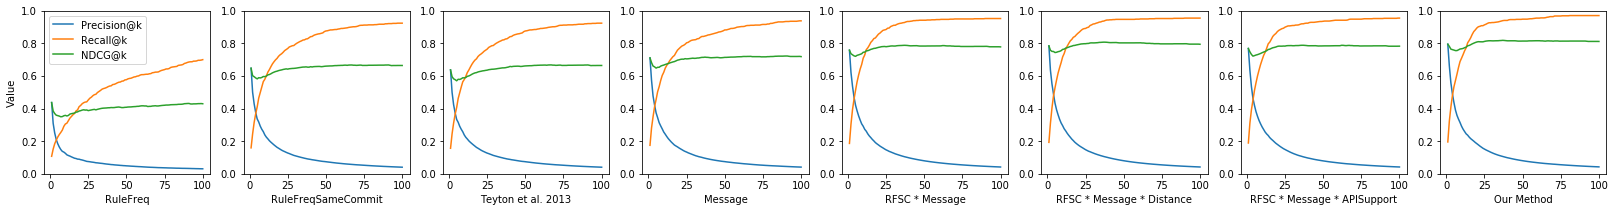

In [13]:
fig, axes = plt.subplots(1, len(methods), figsize=(3.5 * len(methods), 3))
for i, result in enumerate(results):
    x = list(range(1, len(result["Precision-C@k"]) + 1))
    axes[i].plot(x, result["Precision-C@k"], label="Precision@k")
    axes[i].plot(x, result["Recall-C@k"], label="Recall@k")
    axes[i].plot(x, result["NDCG-C@k"], label="NDCG@k")
    axes[i].set_xlabel(result["Name"])
    axes[i].set_ylim([0, 1])
    if i == 0:
        axes[i].set_ylabel("Value")
        axes[i].legend()
fig.show()
fig.savefig("pic/metric-trend.pdf", bbox_inches="tight")

In [14]:
vals = [0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
params = []
for loc in range(0, 4):
    for i in vals:
        param = [1, 1, 1, 1]
        param[loc] = i
        params.append((str(param), method, param))
pool = multiprocessing.Pool(12)
results = pool.starmap(parallel_worker, params)
pool.close()
for result in results:
    print_one_line_evaluation_result(result)

[0.2, 1, 1, 1]                : Precision@1 = 0.7632, MRR = 0.8350, Recall@5 = 0.5149, Recall@10 = 0.6869, Recall@20 = 0.8344, NDCG@10 = 0.7408
[0.4, 1, 1, 1]                : Precision@1 = 0.7895, MRR = 0.8513, Recall@5 = 0.5252, Recall@10 = 0.6908, Recall@20 = 0.8486, NDCG@10 = 0.7537
[0.6, 1, 1, 1]                : Precision@1 = 0.7947, MRR = 0.8528, Recall@5 = 0.5304, Recall@10 = 0.6999, Recall@20 = 0.8629, NDCG@10 = 0.7593
[0.8, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8473, Recall@5 = 0.5317, Recall@10 = 0.7076, Recall@20 = 0.8745, NDCG@10 = 0.7622
[1.0, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8465, Recall@5 = 0.5304, Recall@10 = 0.7089, Recall@20 = 0.8810, NDCG@10 = 0.7621
[1.5, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8448, Recall@5 = 0.5317, Recall@10 = 0.7115, Recall@20 = 0.8823, NDCG@10 = 0.7610
[2.0, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8441, Recall@5 = 0.5278, Recall@10 = 0.7115, Recall@20 = 0.8797, NDCG@10 =